In [1]:
from geopandas import read_file
import geopandas as gpd
from pandas import read_excel
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# CARICAMENTO DATI EUROPEI (Confini amministrativi)
# Fonte: Eurostat Gisco
# https://ec.europa.eu/eurostat/web/gisco/geodata/statistical-units/local-administrative-units
europa = read_file("LAU_RG_01M_2023_3035/LAU_RG_01M_2023_3035.shp")

In [3]:
# ELABORAZIONE DATI SLOVENIA
# Fonte: Statistični urad Republike Slovenije (SURS)
# https://www.stat.si/popis2002/en/rezultati/rezultati_red.asp?ter=OBC&st=7
dati_slovenia = read_excel("OBC-T-07eng.xls", sheet_name="List1", skiprows=4)

# Pulizia e ridenominazione colonne
dati_slovenia = dati_slovenia.rename(columns={
    "Municipality": "comune",
    "Italian": "venetofoni",
    "Total": "totale"
})

# Trattamento valori speciali e calcolo percentuale
dati_slovenia["venetofoni"] = dati_slovenia["venetofoni"].replace(["-", "z"], 0.0).astype(float)
dati_slovenia["venetofoni"] = dati_slovenia["venetofoni"] / dati_slovenia["totale"]

# Creazione base dati pulita
dati_slovenia_pulito = dati_slovenia[['comune', 'venetofoni']].copy()
dati_slovenia_pulito = dati_slovenia_pulito.dropna(subset=['comune', 'venetofoni'])
dati_slovenia_pulito["comune"] = dati_slovenia_pulito["comune"].str.lower()

# Aggiunta speciale per Ankaran (stesso valore di Capodistria)
valore_capodistria = dati_slovenia_pulito.loc[
    dati_slovenia_pulito["comune"] == "koper/capodistria",
    "venetofoni"
].values[0]

dati_slovenia_pulito = pd.concat([
    dati_slovenia_pulito,
    pd.DataFrame([["ankaran", valore_capodistria]], 
    columns=["comune", "venetofoni"])
], ignore_index=True)

/var/folders/mt/zyn6947x2hd43nqjjng1jyrh0000gn/T/ipykernel_86520/4187291378.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dati_slovenia["venetofoni"] = dati_slovenia["venetofoni"].replace(["-", "z"], 0.0).astype(float)


In [4]:
# ELABORAZIONE DATI CROAZIA
# Fonte: Državni zavod za statistiku (DZS)
# https://dzs.gov.hr/u-fokusu/popis-2021/88
dati_croazia = read_excel("popis_2021-stanovnistvo_po_gradovima_opcinama.xlsx", sheet_name="4.", skiprows=7)

# Pulizia e ridenominazione colonne
dati_croazia_pulito = dati_croazia.rename(columns={
    "Grad/općina\nTown/Municipality ": "comune",
    "Talijanski, %   \nItalian, %": "venetofoni"
})
dati_croazia_pulito = dati_croazia_pulito[['comune', 'venetofoni']].copy()

# Standardizzazione nomi comuni
dati_croazia_pulito["comune"] = dati_croazia_pulito["comune"].str.replace("–", "-", regex=False)

# Correzione nome specifico
dati_croazia_pulito.loc[dati_croazia_pulito["comune"] == "Kaštelir-Labinci - Castelliere-S. Domenica", "comune"] = "Kaštelir-Labinci - Castelliere"

# Pulizia valori venetofoni
dati_croazia_pulito = dati_croazia_pulito.dropna(subset=['comune', 'venetofoni'])
dati_croazia_pulito["comune"] = dati_croazia_pulito["comune"].str.lower()
dati_croazia_pulito["venetofoni"] = dati_croazia_pulito["venetofoni"].replace("-", pd.NA)
dati_croazia_pulito = dati_croazia_pulito.groupby('comune', as_index=False)['venetofoni'].sum()

In [5]:
# PREPARAZIONE DATI GEOGRAFICI

# Filtra Slovenia e Croazia dai confini europei
slovenia_geo = europa[europa["CNTR_CODE"] == "SI"]
slovenia_geo = slovenia_geo[['LAU_NAME', 'geometry']].copy()
slovenia_geo = slovenia_geo.rename(columns={"LAU_NAME": "comune"})
slovenia_geo["comune"] = slovenia_geo["comune"].str.lower()

croazia_geo = europa[europa["CNTR_CODE"] == "HR"]
croazia_geo = croazia_geo[['LAU_NAME', 'geometry']].copy()
croazia_geo = croazia_geo.rename(columns={"LAU_NAME": "comune"})
croazia_geo.loc[croazia_geo["comune"] == "Murter - Kornati", "comune"] = "Murter-Kornati"
croazia_geo = croazia_geo[croazia_geo["comune"] != "Grad Zagreb"]
croazia_geo["comune"] = croazia_geo["comune"].str.lower()

# Caricamento quartieri di Zagabria
# https://data.codeforcroatia.org/datasets/adm-granice-gradovi-opcine/
zagreb = read_file("adm_granice_gradovi_opcine.geojson")
zagreb = zagreb[zagreb["admin_level"] == 9.0]
zagreb = zagreb[
    (zagreb["name"] == "Gradska četvrt Brezovica") |
    (zagreb["name"] == "Gradska četvrt Črnomerec") |
    (zagreb["name"] == "Donja Dubrava") |
    (zagreb["name"] == "Gradska četvrt Donji grad") |
    (zagreb["name"] == "Gornja Dubrava") |
    (zagreb["name"] == "Gradska četvrt Gornji grad - Medveščak") |
    (zagreb["name"] == "Maksimir") |
    (zagreb["name"] == "Gradska četvrt Novi Zagreb - istok") |
    (zagreb["name"] == "Gradska četvrt Novi Zagreb - zapad") |
    (zagreb["name"] == "Gradska četvrt Peščenica - Žitnjak") |
    (zagreb["name"] == "Podsljeme") |
    (zagreb["name"] == "Gradska četvrt Podsused - Vrapče") |
    (zagreb["name"] == "Gradska četvrt Stenjevec") |
    (zagreb["name"] == "Gradska četvrt Trešnjevka - jug") |
    (zagreb["name"] == "Gradska četvrt Trešnjevka - sjever") |
    (zagreb["name"] == "Gradska četvrt Trnje")
]
zagreb["name"] = zagreb["name"].str.replace("Gradska četvrt ", "", regex=False)
zagreb = zagreb[['name', 'geometry']].copy()
zagreb = zagreb.rename(columns={"name": "comune"})
zagreb["comune"] = zagreb["comune"].str.lower()
zagreb = zagreb.to_crs(croazia_geo.crs)

# Unione dati geografici Croazia
croazia_geo = gpd.pd.concat([croazia_geo, zagreb], ignore_index=True)

In [6]:
# UNIONE DATI DEMOGRAFICI E GEOGRAFICI
slovenia_filtrata = slovenia_geo[slovenia_geo['comune'].isin(dati_slovenia_pulito['comune'])]
slovenia_unita = slovenia_filtrata.merge(dati_slovenia_pulito, on='comune', how='left')

croazia_filtrata = croazia_geo[croazia_geo['comune'].isin(dati_croazia_pulito['comune'])]
croazia_unita = croazia_filtrata.merge(dati_croazia_pulito, on='comune', how='left')

# Unione finale
mappa_finale = gpd.pd.concat([croazia_unita, slovenia_unita], ignore_index=True)

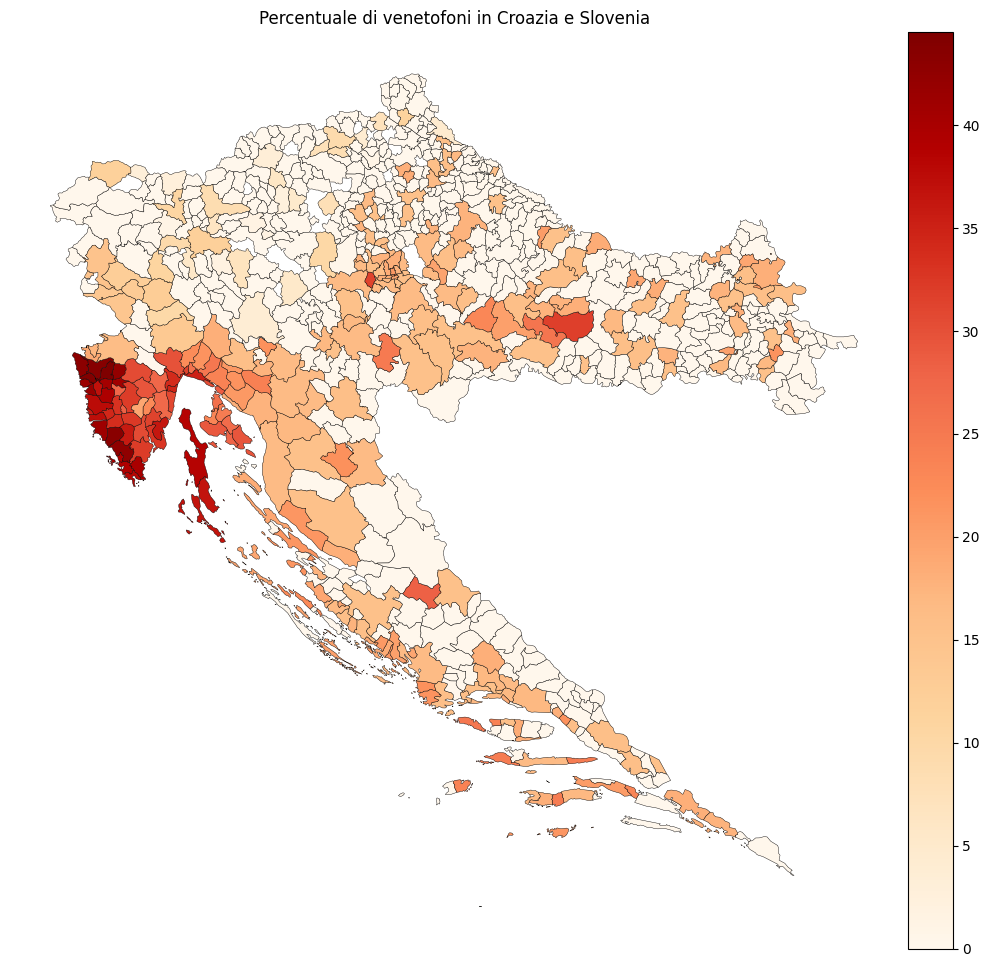

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10, 10))

# italia_geo = europa[europa["CNTR_CODE"] == "IT"]
# italia_geo.plot(
#     edgecolor="black", 
#     linewidth=0.3,
#     ax=ax,
# )

mappa_finale.plot(
    column="venetofoni", 
    cmap="OrRd", 
    legend=False, 
    edgecolor="black", 
    linewidth=0.3,
    ax=ax,
    # missing_kwds={"color": "lightgrey"}
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

sm = plt.cm.ScalarMappable(
    cmap="OrRd",
    norm=plt.Normalize(
        vmin=mappa_finale["venetofoni"].min(), 
        vmax=mappa_finale["venetofoni"].max()
    )
)
sm._A = []
fig.colorbar(sm, cax=cax)

ax.set_title("Percentuale di venetofoni in Croazia e Slovenia", fontsize=12)
ax.axis("off")

plt.tight_layout()
plt.show()